In [2]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from collections import Counter

from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag

import warnings
warnings.filterwarnings('ignore')

In [48]:
df=pd.read_csv('train_malignant.csv')

In [7]:
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
df_test=pd.read_csv('test_malignant.csv')
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# EDA

In [5]:
df.shape

(159571, 8)

The training dataset has 159571 rows and 8 columns

In [6]:
df_test.shape

(153164, 2)

The test dataset has 153164 rows and 2 columns

<AxesSubplot:>

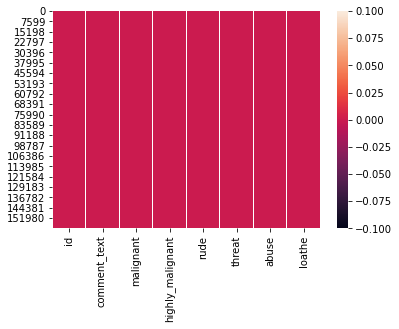

In [7]:
sns.heatmap(df.isnull())

We don't have any null values in our dataset

In [49]:
df.drop(['id'],axis=1,inplace=True)

Dropping id columns since it is a useless feature

In [9]:
df.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


All variables are categorical variables, so there is no scope for outliers

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   comment_text      159571 non-null  object
 1   malignant         159571 non-null  int64 
 2   highly_malignant  159571 non-null  int64 
 3   rude              159571 non-null  int64 
 4   threat            159571 non-null  int64 
 5   abuse             159571 non-null  int64 
 6   loathe            159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


In [10]:
categories=df.columns[1:]

In [11]:
categories

Index(['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe'], dtype='object')

In [12]:
none = df[(df['malignant']!=1) & (df['highly_malignant']!=1) & (df['rude']!=1) & 
                            (df['threat']!=1) & (df['abuse']!=1) & (df['loathe']!=1)]
percent=len(none)/len(df)*100
print('Percentage of good/neutral comments = ',percent)
print('Percentage of negative comments = ', (100-percent))

Percentage of good/neutral comments =  89.83211235124176
Percentage of negative comments =  10.167887648758239


In [50]:
corr=df.corr()
corr.shape

(6, 6)

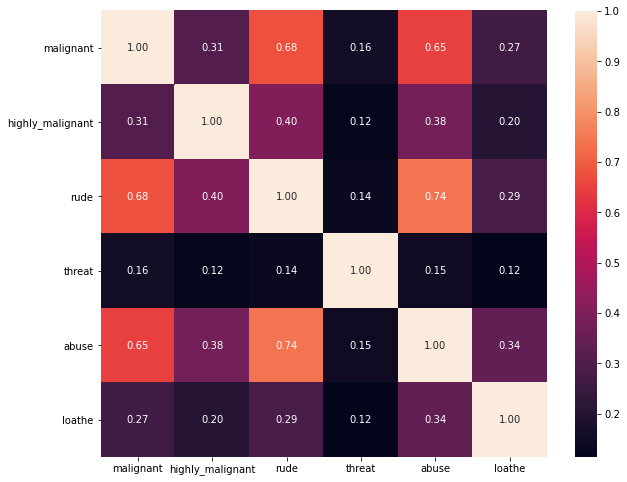

In [51]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,cbar=True,square=True,cbar_kws={'shrink':0.82},fmt='.2f',annot=True,annot_kws={'size':10})
plt.show()

Don't find any multicollinearity problem

In [13]:
df['comment_length'] = df['comment_text'].apply(lambda x: len(str(x)))
df.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67


Adding new feature comment_length to store length of characters

In [14]:
df_test['comment_length'] = df_test['comment_text'].apply(lambda x: len(str(x)))
df_test.head()

,id,comment_text,comment_length
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54
3,00017563c3f7919a,":If you have a look back at the source, the in...",205
4,00017695ad8997eb,I don't anonymously edit articles at all.,41


In [15]:
df['Comment_label'] = df[categories].max(axis=1)
df.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length,Comment_label
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,0


Creating a new feature having Negative Comments and Non-Negative Comments.

In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

Fuction to remove short words

In [17]:
# function to filter using POS tagging. This will be called inside the below function
def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function for data cleaning.
def Processed_data(comments):
    # Replace email addresses with 'email'
    comments=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', comments)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    comments=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',comments)
        
    # getting only words(i.e removing all the special characters)
    comments = re.sub(r'[^\w]', ' ', comments) 
        
    # getting only words(i.e removing all the" _ ")
    comments = re.sub(r'[\_]', ' ', comments) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    comments=re.sub(r'\s+[a-zA-Z]\s+', ' ', comments)
    
    # Removing extra whitespaces
    comments=re.sub(r'\s+', ' ', comments, flags=re.I)

    #converting all the letters of the review into lowercase
    comments = comments.lower()
    
    # splitting every words from the sentences
    comments = comments.split()

    # iterating through each words and checking if they are stopwords or not,
    comments=[word for word in comments if not word in set(STOPWORDS)]
    
    # remove empty tokens
    comments = [text for text in comments if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(comments)

    # considering words having length more than 3only
    comments = [text for text in comments if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS
    comments = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    comments = [text for text in comments if len(text) > 3]
    comments = ' '.join(comments)
    return comments

In [18]:
df['comment_text'] = df['comment_text'].map(lambda comments : clean_text(comments))
df_test['comment_text'] = df_test['comment_text'].map(lambda comments : clean_text(comments))

Replacing short words with actual words

In [19]:
df["clean_comment_text"] = df["comment_text"].apply(lambda x: Processed_data(x))

In [20]:
df_test["clean_comment_text"] = df_test["comment_text"].apply(lambda x: Processed_data(x))

cleaning the comments and storing them in a separate feature for training and testing dataset

In [21]:
df['clean_comment_length'] = df['clean_comment_text'].apply(lambda x: len(str(x)))
df.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length,Comment_label,clean_comment_text,clean_comment_length
0,explanation why the edits made under my userna...,0,0,0,0,0,0,264,0,explanation edits username hardcore metallica ...,123
1,d aww he matches this background colour i am s...,0,0,0,0,0,0,112,0,match background colour seemingly stuck thanks...,64
2,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,233,0,trying edit constantly removing relevant infor...,112
3,more i cannot make any real suggestions on imp...,0,0,0,0,0,0,622,0,real suggestion improvement wondered section s...,315
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,67,0,hero chance remember page,25


In [22]:
df_test['clean_comment_length'] = df_test['clean_comment_text'].apply(lambda x: len(str(x)))
df_test.head()

,id,comment_text,comment_length,clean_comment_text,clean_comment_length
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...,367,bitch rule succesful whats hating mofuckas bit...,184
1,0000247867823ef7,from rfc the title is fine as it is imo,50,title fine,10
2,00013b17ad220c46,sources zawe ashton on lapland,54,source zawe ashton lapland,26
3,00017563c3f7919a,if you have a look back at the source the info...,205,look source information updated correct form g...,104
4,00017695ad8997eb,i do not anonymously edit articles at all,41,anonymously edit article,24


Adding new feature clean_comment_length to store length of characters

In [23]:
# Let's display the wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def Display_wordcloud(data,title):
    feedbackcloud = WordCloud(
        background_color = 'black',
        max_words = 1000,
        max_font_size = 40, 
        scale = 3,
        random_state = 25
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 10),facecolor='g')
    plt.axis('off')
    plt.imshow(feedbackcloud)
    plt.title(f"{title} words")
    plt.show()

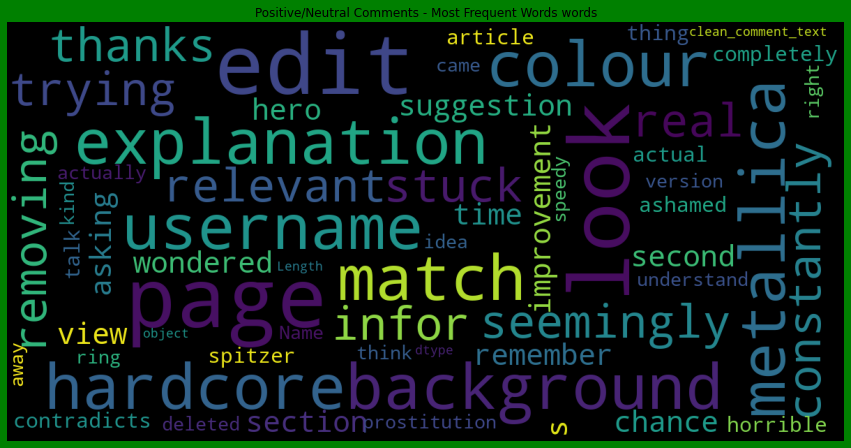

In [24]:
Display_wordcloud(df['clean_comment_text'][df['Comment_label']==0],"Positive/Neutral Comments - Most Frequent Words")

Non-Negative Comments - Frequent words in training data

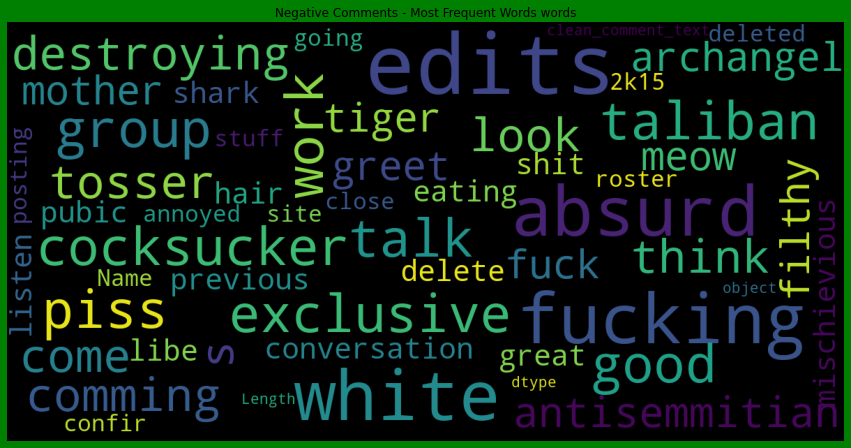

In [25]:
Display_wordcloud(df['clean_comment_text'][df['Comment_label']==1],"Negative Comments - Most Frequent Words")

Negative Comments - Frequent words in training data

In [26]:
# Tokenizing
data=[]
from nltk.tokenize import word_tokenize
for j,i in enumerate(df['clean_comment_text']):
    a=word_tokenize(i,'english')
    data.append(a)

In [27]:
dictionary = corpora.Dictionary(data)
print(dictionary)

Dictionary(167609 unique tokens: ['closure', 'doll', 'edits', 'explanation', 'hardcore']...)


In [28]:
# TF-IDF(term frequency–inverse document frequency) vectorizer
def Tf_idf_train(text):
    tfid = TfidfVectorizer(min_df=3,smooth_idf=False)
    return tfid.fit_transform(text)

In [29]:
# Let's define x, y for modelling
x=Tf_idf_train(df['clean_comment_text'])
x.shape

(159571, 43246)

In [30]:
y = df['Comment_label'].values
y.shape

(159571,)

# Model Building

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve

In [34]:
LR=LogisticRegression()
DTC=DecisionTreeClassifier()
RFC=RandomForestClassifier()
ABC=AdaBoostClassifier()
KNN=KNeighborsClassifier()
GBC=GradientBoostingClassifier()

models=[('LogisticRegression',LR),('DecisionTreeClassifier',DTC),('RandomForestClassifier',RFC),('AdaBoostClassifier',ABC),
       ('KneighborsClassifier',KNN),('GradientBoostingClassifier',GBC)]
models

[('LogisticRegression', LogisticRegression()),
 ('DecisionTreeClassifier', DecisionTreeClassifier()),
 ('RandomForestClassifier', RandomForestClassifier()),
 ('AdaBoostClassifier', AdaBoostClassifier()),
 ('KneighborsClassifier', KNeighborsClassifier()),
 ('GradientBoostingClassifier', GradientBoostingClassifier())]

In [35]:
Model=[]
Acc_score=[]
cvs=[]


for name,model in models:
    print(name)
    Model.append(name)
    print(model)
    
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42,stratify=y)
    model.fit(x_train,y_train)
    

    y_pred=model.predict(x_test)
    acc_score=accuracy_score(y_test,y_pred)
    print('Accuracy Score : ',acc_score)
    
    
    cv_score=cross_val_score(model,x,y,cv=5).mean()
    print('Cross Val Score : ', cv_score)
    

# Classification Report     
    print('Classification Report:\n',classification_report(y_test,y_pred))

LogisticRegression
LogisticRegression()
Accuracy Score :  0.9542776928283158
Cross Val Score :  0.9535065883970189
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     35837
           1       0.92      0.60      0.73      4056

    accuracy                           0.95     39893
   macro avg       0.94      0.80      0.85     39893
weighted avg       0.95      0.95      0.95     39893

DecisionTreeClassifier
DecisionTreeClassifier()
Accuracy Score :  0.9388113202817537
Cross Val Score :  0.9397384224215063
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     35837
           1       0.71      0.68      0.69      4056

    accuracy                           0.94     39893
   macro avg       0.84      0.82      0.83     39893
weighted avg       0.94      0.94      0.94     39893

RandomForestClassifier
RandomForestClassifier()
Accuracy Sco

Selecting Random Forest Classifier as the best model since it gives the highest sore for accuracy

# Hyperparameter Tuning

In [36]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.25,stratify=y)
parameters={'bootstrap': [True, False],
            'max_depth': [10, 50, 100],
            'min_samples_leaf': [1, 2, 3, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [100, 300, 500, 800, 1200],
            'criterion':['gini','entropy'],
            'max_features':['auto','sqrt','log2']}


rfc=RandomForestClassifier()
clf=RandomizedSearchCV(rfc, cv=5, param_distributions=parameters)
clf.fit(x_train,y_train)

print(clf.best_params_)

{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': True}


In [37]:
Final_model=RandomForestClassifier(n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features='sqrt',max_depth=100, criterion='entropy', bootstrap=True)
Final_model.fit(x_train,y_train)
pred=Final_model.predict(x_test)
acc=accuracy_score(y_test,pred)
print('Accuracy:',acc*100)

Accuracy: 92.0186498884516


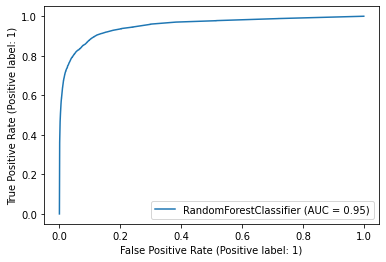

In [40]:
plot_roc_curve(RFC,x_test,y_test)
plt.show()

In [41]:
def Tf_idf_test(text):
    tfid = TfidfVectorizer(max_features=43246,smooth_idf=False)
    return tfid.fit_transform(text)

# TEST PREDICTION

In [42]:
testing_data=Tf_idf_test(df_test['clean_comment_text'])

In [43]:
testing_data.shape

(153164, 43246)

In [44]:
Prediction=RFC.predict(testing_data)
df_test['Predicted values']=Prediction
df_test

,id,comment_text,comment_length,clean_comment_text,clean_comment_length,Predicted values
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...,367,bitch rule succesful whats hating mofuckas bit...,184,0
1,0000247867823ef7,from rfc the title is fine as it is imo,50,title fine,10,0
2,00013b17ad220c46,sources zawe ashton on lapland,54,source zawe ashton lapland,26,0
3,00017563c3f7919a,if you have a look back at the source the info...,205,look source information updated correct form g...,104,0
4,00017695ad8997eb,i do not anonymously edit articles at all,41,anonymously edit article,24,0
...,...,...,...,...,...,...
153159,fffcd0960ee309b5,i totally agree this stuff is nothing but too ...,60,totally agree stuff long crap,29,0
153160,fffd7a9a6eb32c16,throw from out field to home plate does it get...,198,throw field home plate faster throwing direct ...,85,0
153161,fffda9e8d6fafa9e,okinotorishima categories i see your changes a...,423,okinotorishima category change agree correct g...,212,0
153162,fffe8f1340a79fc2,one of the founding nations of the eu germany ...,502,founding nation germany return similar israel ...,275,0


In [45]:
df_test[df_test['Predicted values']==1].head()

,id,comment_text,comment_length,clean_comment_text,clean_comment_length,Predicted values
84,002046a2e5669735,ices could hardly be labelled as a very obviou...,727,hardly labelled obviously seal hunting organiz...,376,1
104,0028b002aacc20cc,catdiffuse i think the best idea would be to c...,283,catdiffuse think best idea check whatlinkshere...,113,1
109,002a3ebaaa51f17a,maybe you should have a read of that one too s...,233,maybe read decided assist article wikipedia ex...,105,1
123,00316955ef4b0fee,understandable i have had a lot of problems wi...,266,understandable problem past particularly regar...,112,1
125,0031d0649f4a266b,name in the introductory paragraph i have alwa...,588,introductory paragraph told incorrect automati...,247,1


In [46]:
df_test.to_csv('Malignant_Predict.csv')

In [47]:
import joblib
joblib.dump(RFC,'Malignant_Predict.pkl')

['Malignant_Predict.pkl']